**BBM473 Database Laboratory (Spring  2022)**


Exercise 8: Optimization of Relational Algebra Expressions
==================================



First, execute the following codes below.

**Note:** You may need to install `markdown`:

    $ pip install markdown

In [ ]:
%load_ext sql
%sql sqlite://

%load_ext autoreload
%autoreload 2

# To help render markdown
from IPython.core.display import display, Markdown
from markdown import markdown
def render_markdown_raw(m): return display(Markdown(markdown(m))) # must be last element of cell.
def render_markdown(m): return render_markdown_raw(m.toMD())
def cost_markdown(q): 
    q.reset_count()
    get_result(q) # run the counters
    return display(Markdown(markdown("Total Reads: {0}\n\n".format(q.total_count()) + q.toCount(0))))

# import the relational algbera operators
from relation_algebra import Select, Project, Union, NJoin, CrossProduct, BaseRelation
from relation_algebra import get_result, compare_results

from display_tools import side_by_side

import random

def check_results(a, b): assert compare_results(a, b), "Result is not correct. Try again."

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%%sql
drop table if exists R; create table R(A int, B int);
drop table if exists S; create table S(B int, C int);
drop table if exists T; create table T(C int, D int);

 * sqlite://
Done.
Done.
Done.
Done.
Done.
Done.


[]

We start by generating some sample data for relations $R$ and $S$:

In [ ]:
for b in range(0,5,1):
    for a in range(0,10,2):
        %sql INSERT INTO R VALUES (:a, :b);
for b in range(0,5,1):
    for c in range(0,10,2):
        %sql INSERT INTO S VALUES (:b, :c);
for c in range(0,5,1):
    for d in range(0,10,2):
        %sql INSERT INTO T VALUES (:c, :d);

 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite://
1 rows affected.
 * sqlite:

Then, let's look at the following RA expression:

In [ ]:
r = %sql SELECT * FROM R;
R = BaseRelation(r, name="R")
s = %sql SELECT * FROM S;
S = BaseRelation(s, name="S")

x = Project(["B"], NJoin(R,S))
render_markdown(x)
print(get_result(x))

 * sqlite://
Done.
 * sqlite://
Done.


<p>$\Pi_{B}$(( R(A,B) ) $\Join_{B}$ ( S(B,C) ))</p>

[(0,), (1,), (2,), (3,), (4,)]


Let's look at what's going on under the hood using the `cost_markdown` function:

In [ ]:
cost_markdown(x)

<p>Total Reads: 775</p>
<ul>
<li>$\Pi_{['B']}$ [tuples read in: 125 out: 5]<ul>
<li>$\Join_{B}$ [tuples read in: 650 out: 125]<ul>
<li>R(A,B) has 25 tuples </li>
<li>S(B,C) has 25 tuples </li>
</ul>
</li>
</ul>
</li>
</ul>

Note that there are several simplifying assumptions in how we compute cost here.  For one, note that we don't assume anything about being able to cache intermediate results in any way (either in buffer or on disk).  For another one, note how is the join done... what algorithm are we using here?

Note that we can also just get the total count of reads:

In [ ]:
x.total_count()

775

### Task 1: Optimizing the IO Cost

Can you find a logically equivalent form that uses fewer total reads?

In [ ]:
x_r = NJoin(Project(["B"], R), Project(["B"], S))

render_markdown(x_r)
check_results(x, x_r)

print(get_result(x_r))
cost_markdown(x_r)

<p>( $\Pi_{B}$(R(A,B)) ) $\Join_{B}$ ( $\Pi_{B}$(S(B,C)) )</p>

[(0,), (1,), (2,), (3,), (4,)]


<p>Total Reads: 180</p>
<ul>
<li>$\Join_{B}$ [tuples read in: 30 out: 5]<ul>
<li>$\Pi_{['B']}$ [tuples read in: 25 out: 5]<ul>
<li>R(A,B) has 25 tuples </li>
</ul>
</li>
<li>$\Pi_{['B']}$ [tuples read in: 125 out: 25]<ul>
<li>S(B,C) has 25 tuples </li>
</ul>
</li>
</ul>
</li>
</ul>

### Task 2: Comparing costs (40 pts.)

Let's explore how the cost of the two expressions compare as the data size increases, and with different numbers of distinct values in the data.  Given that $R$ has $N$ values, $S$ has $M$ values, you can assume that $N=M$ to simplify, and that they will both have _the same number of unique $B$ values_.

You can do this any way you choose, but we outline one way below:

We'll start with a function for each cost that will take as input:
* The number of tuples in $R$, $N$
* The number of distinct $B$ values in $R$, $N_B$
* The number of tuples in $R\Join_B S$, $O_1$
* The number of tuples in $\Pi_B(R\Join_B S)$, $O_2$

`def cost_1` calculates reads for -> $\Pi_{B}$(( R(A,B) ) $\Join_{B}$ ( S(B,C) )) or `Project(["B"], NJoin(R,S))`

`def cost_2` calculates reads for -> Your answer for the Task 1

Your function should return the total number of reads as in the `cost_markdown` function

In [ ]:
def cost_1(N, M, N_B, M_B, O_1, O_2):
    # cost = (cost for reading nested loop join for R and S) + (cost of reading output in order to do projection)
    cost = (N + (N * M)) + O_1
    return cost

def cost_2(N, M, N_B, M_B, O_1, O_2):
    # cost = (cost for projections + cost for 'loops of' nested loop join) + (cost of nested loop join)
    cost = (N + (N_B * M)) + (N_B + (N_B * M_B))
    return cost

print(cost_1(25, 25, 5, 5, 125, 5))
print(cost_2(25, 25, 5, 5, 125, 5))

775
180


We can plot this as a function of $N$ (assume $N=M$ for simplicity), given 5 distinct $B$ values and a rough estimate of the intermediate output counts:

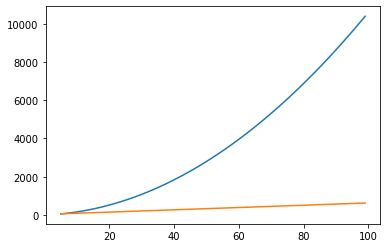

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

B = 5
nrange = range(5,100)

# Plot
plt.plot(nrange, [cost_1(n, n, B, B, n*B, B) for n in nrange])
plt.plot(nrange, [cost_2(n, n, B, B, n*B, B) for n in nrange])
plt.show()

### Task 3: Optimizing some other expressions

Can you optimize the below expressions, using the tools above?

#### Task 3.1

In [ ]:
x = Select("A", 2, Project(["A","C"], NJoin(R,S)))
render_markdown(x)
print(get_result(x))
cost_markdown(x)

<p>$\sigma_{A=2}$($\Pi_{A,C}$(( R(A,B) ) $\Join_{B}$ ( S(B,C) )))</p>

[(2, 8), (2, 2), (2, 6), (2, 0), (2, 4)]


<p>Total Reads: 800</p>
<ul>
<li>$\sigma_{A=2}$ [tuples read in: 25 out: 5]<ul>
<li>$\Pi_{['A', 'C']}$ [tuples read in: 125 out: 25]<ul>
<li>$\Join_{B}$ [tuples read in: 650 out: 125]<ul>
<li>R(A,B) has 25 tuples </li>
<li>S(B,C) has 25 tuples </li>
</ul>
</li>
</ul>
</li>
</ul>
</li>
</ul>

In [ ]:
x_r = Project(["A","C"], NJoin(Select("A", 2, R), S))

render_markdown(x_r)
check_results(x, x_r)

print(get_result(x_r))
cost_markdown(x_r)

<p>$\Pi_{A,C}$(( $\sigma_{A=2}$(R(A,B)) ) $\Join_{B}$ ( S(B,C) ))</p>

[(2, 6), (2, 8), (2, 0), (2, 2), (2, 4)]


<p>Total Reads: 180</p>
<ul>
<li>$\Pi_{['A', 'C']}$ [tuples read in: 25 out: 5]<ul>
<li>$\Join_{B}$ [tuples read in: 130 out: 25]<ul>
<li>$\sigma_{A=2}$ [tuples read in: 25 out: 5]<ul>
<li>R(A,B) has 25 tuples </li>
</ul>
</li>
<li>S(B,C) has 25 tuples </li>
</ul>
</li>
</ul>
</li>
</ul>

#### Task 3.2

In [ ]:
t = %sql SELECT * FROM T;
T = BaseRelation(t, name="T")

x = Select("C", 0, Project(["A","C"], Select("B", 0, NJoin(NJoin(R, S), T))))
render_markdown(x)
print(get_result(x))
cost_markdown(x)

 * sqlite://
Done.


<p>$\sigma_{C=0}$($\Pi_{A,C}$($\sigma_{B=0}$(( ( R(A,B) ) $\Join_{B}$ ( S(B,C) ) ) $\Join_{C}$ ( T(C,D) ))))</p>

[(0, 0), (8, 0), (6, 0), (2, 0), (4, 0)]


<p>Total Reads: 4365</p>
<ul>
<li>$\sigma_{C=0}$ [tuples read in: 15 out: 5]<ul>
<li>$\Pi_{['A', 'C']}$ [tuples read in: 75 out: 15]<ul>
<li>$\sigma_{B=0}$ [tuples read in: 375 out: 75]<ul>
<li>$\Join_{C}$ [tuples read in: 3250 out: 375]<ul>
<li>$\Join_{B}$ [tuples read in: 650 out: 125]<ul>
<li>R(A,B) has 25 tuples </li>
<li>S(B,C) has 25 tuples </li>
</ul>
</li>
<li>T(C,D) has 25 tuples </li>
</ul>
</li>
</ul>
</li>
</ul>
</li>
</ul>
</li>
</ul>

In [ ]:
x_r = Project(["A","C"], NJoin(Select("C", 0, NJoin(Select("B", 0, R), Select("B", 0, S))), Project(["C"], Select("C", 0, T))))

render_markdown(x_r)
check_results(x, x_r)

print(get_result(x_r))
cost_markdown(x_r)

<p>$\Pi_{A,C}$(( $\sigma_{C=0}$(( $\sigma_{B=0}$(R(A,B)) ) $\Join_{B}$ ( $\sigma_{B=0}$(S(B,C)) )) ) $\Join_{C}$ ( $\Pi_{C}$($\sigma_{C=0}$(T(C,D))) ))</p>

[(0, 0), (8, 0), (6, 0), (2, 0), (4, 0)]


<p>Total Reads: 370</p>
<ul>
<li>$\Pi_{['A', 'C']}$ [tuples read in: 5 out: 5]<ul>
<li>$\Join_{C}$ [tuples read in: 10 out: 5]<ul>
<li>$\sigma_{C=0}$ [tuples read in: 25 out: 5]<ul>
<li>$\Join_{B}$ [tuples read in: 30 out: 25]<ul>
<li>$\sigma_{B=0}$ [tuples read in: 25 out: 5]<ul>
<li>R(A,B) has 25 tuples </li>
</ul>
</li>
<li>$\sigma_{B=0}$ [tuples read in: 125 out: 25]<ul>
<li>S(B,C) has 25 tuples </li>
</ul>
</li>
</ul>
</li>
</ul>
</li>
<li>$\Pi_{['C']}$ [tuples read in: 25 out: 5]<ul>
<li>$\sigma_{C=0}$ [tuples read in: 125 out: 25]<ul>
<li>T(C,D) has 25 tuples </li>
</ul>
</li>
</ul>
</li>
</ul>
</li>
</ul>
</li>
</ul>

### Task 4: Optimizing indexes

In [ ]:
%load_ext sql
%sql sqlite:///complaint.db
import time
%sql drop index if exists helpful_index;
%sql analyze

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
   sqlite://
 * sqlite:///complaint.db
Done.
   sqlite://
 * sqlite:///complaint.db
Done.


[]

In [ ]:
%%sql
PRAGMA index_list('complaints');

   sqlite://
 * sqlite:///complaint.db
Done.


seq,name,unique,origin,partial
0,zip_index,0,c,0
1,state_product_index,0,c,0
2,state_index,0,c,0


Let's play with the [consumer complaint database](https://catalog.data.gov/dataset/consumer-complaint-database) from data.gov

In [ ]:
%sql select count(*) from complaints;

   sqlite://
 * sqlite:///complaint.db
Done.


count(*)
79468


In [ ]:
%sql select * from complaints limit 5;

   sqlite://
 * sqlite:///complaint.db
Done.


Date_received,Product,Subproduct,Issue,Subissue,Consumer_narrative,Company_public_response,Company,State,ZIP_code,Submitted_via,Date_sent_to_company,Company_response,Timely_response,Consumer_disputed,Complaint_ID
12/30/2015,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",,,Company chooses not to provide a public response,U.S. Bancorp,TN,38138,,N/A,Referral,01/05/2016,Closed with explanation,Yes
12/12/2015,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",,,Company chooses not to provide a public response,Citibank,NY,13021,,N/A,Referral,12/23/2015,Closed with explanation,Yes
12/02/2015,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",,,,Nationstar Mortgage,MI,49102,,N/A,Referral,12/17/2015,Closed with explanation,Yes
12/02/2015,Bank account or service,Other bank product/service,"Account opening, closing, or management",,,Company chooses not to provide a public response,Wells Fargo & Company,,,,N/A,Referral,12/07/2015,Closed with explanation,Yes
12/22/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",,,,Nationstar Mortgage,FL,33484,Older American,Consent not provided,Web,01/06/2016,Closed with explanation,Yes


The syntax to create a view is below
> create index (index_name) on (table)(attributes)

In [ ]:
%%sql drop index if exists zip_index;
create index zip_index on complaints(zip_code);
analyze

   sqlite://
 * sqlite:///complaint.db
Done.
Done.
Done.


[]

In [ ]:
%%sql
select zip_code, count(*) as c 
from complaints group by zip_code 
order by c desc limit 5;

   sqlite://
 * sqlite:///complaint.db
Done.


ZIP_code,c
None,21619
Closed with explanation,4267
,760
Closed with non-monetary relief,646
Yes,607


In [ ]:
%%sql select product, count(*)
from complaints c1 where ZIP_CODE = '48382'
group by product;

   sqlite://
 * sqlite:///complaint.db
Done.


Product,count(*)
Mortgage,126
Student loan,1


Let's get down to business... Indexing complainers!

For pedagogical purposes, we'll use _likelihood_ function:
  * likelihood(X,Y) does not change X's value 
  * instead it tells the DBMS the fraction of calls on which we believe X holds.
      * 0.0 is lowest, 1.0 is highest.
  * It's a form of _hint_ for the optimizer

In [ ]:
%%sql 
explain query plan 
select product, count(*) from complaints c1 
where likelihood(ZIP_CODE = '48383' or ZIP_CODE='44444', 1.0)
group by product;

   sqlite://
 * sqlite:///complaint.db
Done.


selectid,order,from,detail
0,0,0,SCAN TABLE complaints AS c1
0,0,0,USE TEMP B-TREE FOR GROUP BY


In [ ]:
%%sql 
explain query plan 
select product, count(*) from complaints c1 
where likelihood(ZIP_CODE = '48383' or ZIP_CODE='44444', 0.0)
group by product;

   sqlite://
 * sqlite:///complaint.db
Done.


selectid,order,from,detail
0,0,0,SEARCH TABLE complaints AS c1 USING INDEX zip_index (ZIP_code=?)
0,0,0,EXECUTE LIST SUBQUERY 1
0,0,0,USE TEMP B-TREE FOR GROUP BY


So... does it make a difference in execution time? 

... Well, some it's a small database in memory...

In [ ]:
start_scan = time.time()
%sql select product, count(*) from complaints c1 where likelihood(ZIP_CODE = '48382' or ZIP_CODE='44444', 1.0) group by product;
scan_time = time.time() - start_scan

start_index = time.time()
%sql select product, count(*) from complaints c1 where likelihood(ZIP_CODE = '48382' or ZIP_CODE='44444', 0.0) group by product;
index_time  = time.time() - start_index
print("time for scan={0} time for index={1}".format(scan_time, index_time))
print("\t So about {0} times faster".format(scan_time/index_time))

   sqlite://
 * sqlite:///complaint.db
Done.
   sqlite://
 * sqlite:///complaint.db
Done.
time for scan=0.03626298904418945 time for index=0.003431081771850586
	 So about 10.568966715308179 times faster


<center>Covering Indexes</center>

We say that an index is _covering_ if all the needed columns are in the index.
 * Needed columns is the union of those in WHERE _and_ SELECT.
 * Means that the query can be answere using the index--without reading the table!

In [ ]:
%%sql drop index if exists helpful_index;
create index helpful_index on 
complaints(zip_code, product, complaint_id);

Which plan happens for this query?
> select product, count(*)<br>
> from complaints <br>
> where likelihood(ZIP_CODE = '48382', 1.0)
> <br>group by product;

NB: Using zip_index, this would be a scan!

In [ ]:
%%sql
explain query plan select product, count(*) 
from complaints c1 
where likelihood(ZIP_CODE = '48382' or ZIP_CODE='44444', 1.0) group by product;

* The index is _smaller_ in absolute data size.
* The DBMS knows this, and it picks the right index!

Summary
-------

* This notebook walks through index creation 
* That index selection is done in a cost based way.
* Introduced the notion of covering index.
* Demonstrated that not only keys to answer query, but attributes returned important component of selection. 